In [1]:
"""
Validation of open-gira power outage model
This notebook compares modelled and observed customer disconnected estimates
Observed data are collated media and goverment reports (CSV files in validation/)
Modelled data are exposure_by_country.nc for the whole IBTrACS storm set
"""

'\nValidation of open-gira power outage model\nThis notebook compares modelled and observed customer disconnected estimates\nObserved data are collated media and goverment reports (CSV files in validation/)\nModelled data are exposure_by_country.nc for the whole IBTrACS storm set\n'

In [2]:
import os
from glob import glob

import geopandas as gpd
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import xarray as xr

/tmp/ipykernel_1439453/2742257982.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# can use alternative backend for interactive plot window (for zooming)
#%matplotlib tkagg

In [5]:
# model outputs
root_path = "/home/fred/projects/open_gira/open-gira/"
tracks_path = os.path.join(root_path, "results/input/IBTrACS/processed/v4.geoparquet")
targets_path = os.path.join(root_path, "results/power/targets_with_iso_a3.geoparquet")
exposure_path = os.path.join(root_path, "results/power/by_storm_set/IBTrACS/exposure_by_country.nc")

# validation data
# https://www.un.org/development/desa/pd/data/household-size-and-composition
household_path = os.path.join(root_path, "undesa_pd_2022_hh-size-composition.xlsx")
# https://gist.githubusercontent.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv
iso_codes = os.path.join(root_path, "iso_codes.csv")
# see source column
outage_paths = glob(os.path.join(root_path, "validation/observed_outages/*.csv"))

In [6]:
# read iso numeric to alpha table
rename_dict = {
    "Country": "name",
    "Alpha-2 code": "iso_a2",
    "Alpha-3 code": "iso_a3",
    "Numeric code": "iso_num"
}
iso = pd.read_csv(iso_codes, usecols=rename_dict.keys())
iso = iso.rename(columns=rename_dict)
# strip out quotes
for c in iso.columns:
    iso[c] = iso[c].str.replace('"', "").str.strip()
iso.iso_num = iso.iso_num.astype(int)

In [7]:
# read household size data
rename_dict = {
    "ISO Code": "iso_num",
    "Reference date (dd/mm/yyyy)": "ref_date",
    "Average household size (number of members)": "mean_household_pop"
}
hh = pd.read_excel(household_path, sheet_name="HH size and composition 2022", header=4, usecols=rename_dict.keys())
hh = hh.rename(columns=rename_dict)
hh.ref_date = pd.to_datetime(hh.ref_date, dayfirst=True)

# any non-numeric value -> NaN (some '..' placeholders in excel data)
hh["mean_household_pop"] = pd.to_numeric(hh["mean_household_pop"], errors="coerce")

# drop any rows without a valid mean household pop
hh = hh[~hh.mean_household_pop.isna()]

# discard all but most recent entry for each territory
hh = hh.sort_values(["ref_date"], ascending=False).drop_duplicates("iso_num", keep="first")

# merge in iso alpha ids (will permit join with outage data)
hh = hh.merge(iso, how="left", on="iso_num")

In [8]:
# now compare population_affected with the exposure_by_country.nc data
ds = xr.open_dataset(exposure_path).rename({"country": "country_iso_a3"})

by_threshold = {}
for threshold in ds.threshold.values:

    # storm loop
    obs_data = {os.path.basename(p).split(".")[0]: pd.read_csv(p) for p in sorted(outage_paths)}
    by_storm = {}
    for event_id, obs in obs_data.items():
        
        try:
            # select model data for given storm and threshold
            mod = ds.customers_affected.sel(dict(event_id=event_id, threshold=threshold)).to_pandas()
        except KeyError:
            # storm has no modelled results for any threshold
            continue
        
        # create a duplicate dataframe for modelled and derived measures (as well as obs)
        by_storm[event_id] = obs.copy()
        
        # bring in demographic data to obs dataframe
        obs = obs.rename(columns={"country_iso_a3": "iso_a3"}).merge(hh, how="left", on="iso_a3")

        for i in range(len(obs)):
            # gap-fill the population_affected numbers where we have customers_affected only
            if pd.isna(obs.loc[i, "population_affected"]):
                by_storm[event_id].loc[i, "population_affected"] = \
                    obs.loc[i, "customers_affected"] * obs.loc[i, "mean_household_pop"]

        # take the largest estimate for each country (we assume reports underestimate outages)
        by_storm[event_id] = by_storm[event_id].groupby("country_iso_a3").max()
        by_storm[event_id] = by_storm[event_id][["population_affected"]]
        by_storm[event_id] = by_storm[event_id].rename(columns={"population_affected": "observed"})

        # modelled customers_affected (really population affected, should change this name!)
        mod.name = "modelled"
        by_storm[event_id] = by_storm[event_id].join(mod)
        by_storm[event_id]["error"] = \
            by_storm[event_id].modelled - by_storm[event_id].observed
        by_storm[event_id]["ratio"] = \
            by_storm[event_id].modelled / by_storm[event_id].observed
        by_storm[event_id]["error_norm"] = \
            by_storm[event_id].error / by_storm[event_id].observed
        by_storm[event_id]["signed_ratio"] = \
            np.sign(by_storm[event_id].error) * by_storm[event_id].ratio

    concat = pd.concat(by_storm)
    concat.index.names = ["event_id", "country_iso_a3"]
    by_threshold[threshold] = concat

# all data with a 3 level multi-index
data = pd.concat(by_threshold, names=["threshold", "event_id", "country_iso_a3"])

# write to disk
data.to_csv("outage_model_validation.csv")

In [9]:
# example data for a given threshold
data.loc[32.5, :, :]

,,observed,modelled,error,ratio,error_norm,signed_ratio
event_id,country_iso_a3,,,,,,
2005236N23285,USA,6723000.00,1.349097e+07,6.767968e+06,2.006689,1.006689,2.006689
2005261N21290,USA,3735000.00,4.070329e+06,3.353288e+05,1.089780,0.089780,1.089780
2005289N18282,USA,8715000.00,7.700070e+06,-1.014930e+06,0.883542,-0.116458,-0.883542
2008238N13293,USA,2739000.00,1.064142e+07,7.902419e+06,3.885147,2.885147,3.885147
2008245N17323,USA,9711000.00,9.470136e+06,-2.408638e+05,0.975197,-0.024803,-0.975197
2011028S13180,AUS,433500.00,1.762983e+05,-2.572017e+05,0.406686,-0.593314,-0.406686
2011233N15301,USA,16658100.00,6.071332e+05,-1.605097e+07,0.036447,-0.963553,-0.036447
2012296N14283,USA,21193014.99,3.353923e+07,1.234622e+07,1.582561,0.582561,1.582561
2013306N07162,PHL,12000000.00,9.278462e+06,-2.721538e+06,0.773205,-0.226795,-0.773205


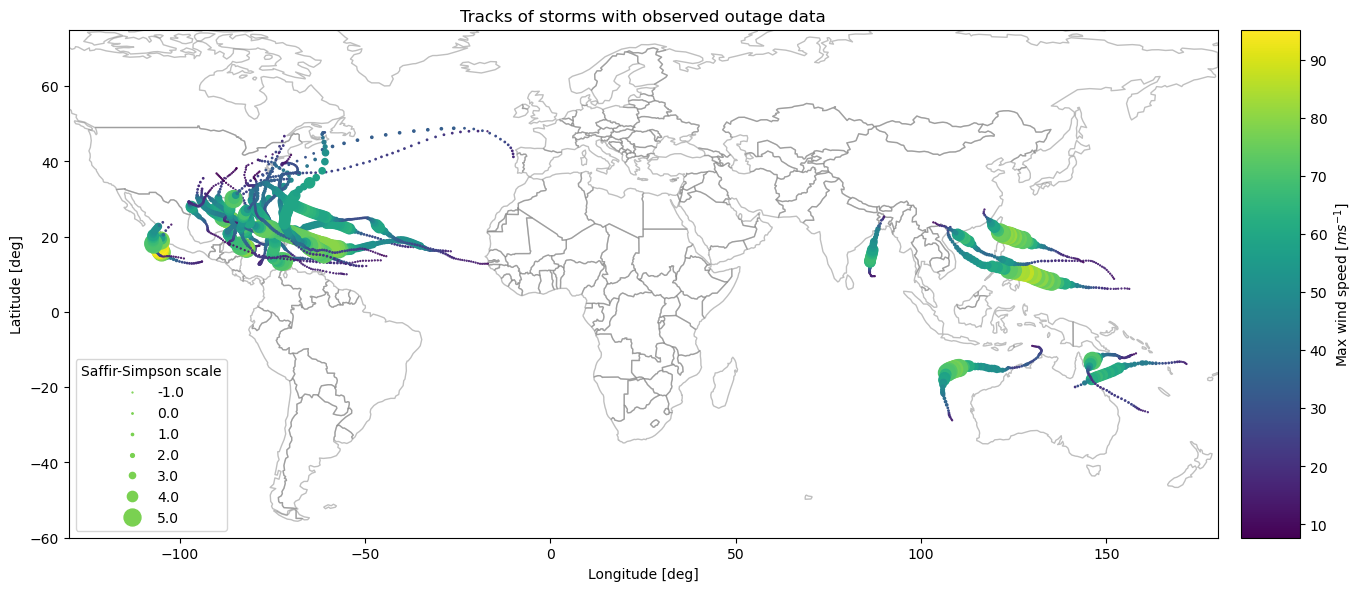

In [10]:
# where are these tracks?
borders = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
tracks = gpd.read_parquet(tracks_path)
tracks = tracks[tracks.track_id.isin(set(data.index.get_level_values("event_id")))]

f, ax = plt.subplots(figsize=(16, 7))

# plot landmasses and political borders
borders.plot(ax=ax, facecolor="none", edgecolor="grey", alpha=0.5)

# plot tracks with colourbar for wind speed intensity
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
markersize = np.exp(tracks.category)
tracks.plot(column="max_wind_speed_ms", ax=ax, s=markersize, cax=cax, legend=True, cmap="viridis")
cax.set_ylabel("Max wind speed $[ms^{-1}]$")

ax.set_xlim(-130, 180)
ax.set_ylim(-60, 75)
ax.set_title("Tracks of storms with observed outage data")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

# second legend for saffir simpson storm classification
saffir_simpson = ax.legend(
    handles=[
        Line2D(
            [],
            [],
            color=plt.get_cmap("viridis")(0.8),
            lw=0,
            marker="o",
            markersize=np.sqrt(b),
            label=np.log(b),
        )
        for b in sorted(set(markersize))
    ],
    loc="lower left",
    title="Saffir-Simpson scale"
)

In [11]:
def categorical_cmap(cmap_name: str, categories: list) -> dict[str: tuple[float]]:
    scalar_mappable = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(0, 1), cmap_name)
    return {code: scalar_mappable.to_rgba(i / len(categories)) for i, code in enumerate(categories)}

# create some colourmaps and persist between plots

# make a country colormap
countries = sorted(set(data.index.get_level_values("country_iso_a3").values))
country_cmap = categorical_cmap("tab20c", countries)

# make a cmap for wind speed thresholds
thresholds = sorted(set(data.index.get_level_values("threshold").values))
wind_cmap = categorical_cmap("plasma", thresholds)

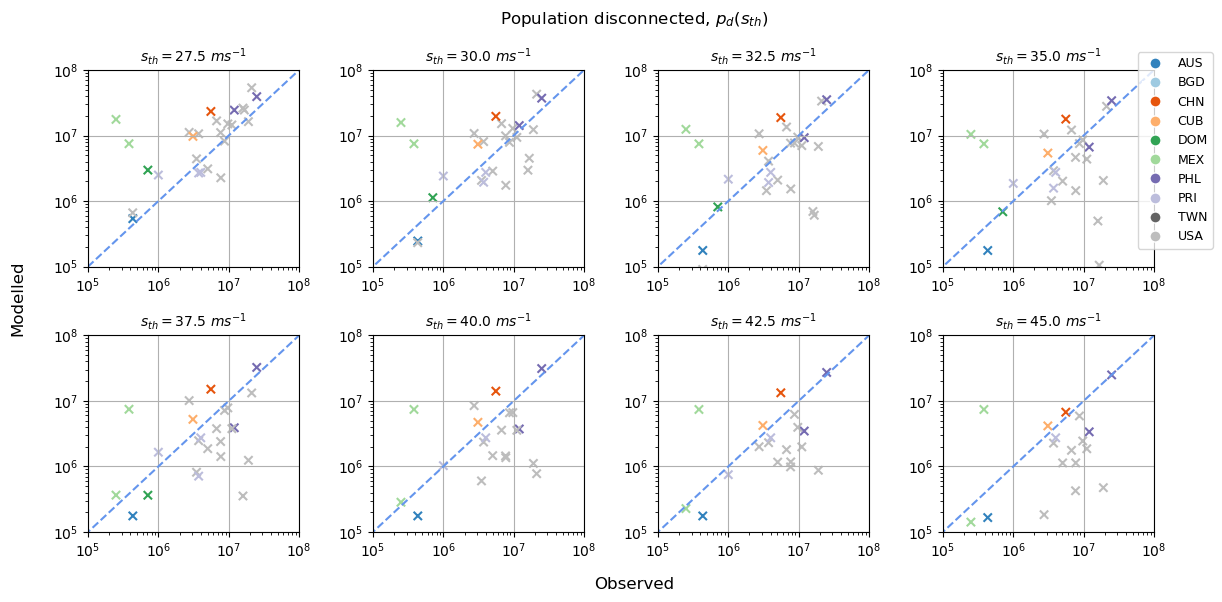

In [99]:
# scatter plot modelled vs. observed by threshold

n = len(thresholds)
ncols = min([n, 4])
nrows = (n // ncols) + (n % ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 + 2.5 * ncols, 2 + 2 * nrows), squeeze=False)

for row in range(nrows):
    for col in range(ncols):

        i = col + (row * ncols)
        ax = axes[row, col]
        
        if i < n:
            threshold = thresholds[i]
            df = data.loc[threshold, :, :]

            # build a list of RGBA values the same length as the data
            colours = [country_cmap[value] for value in df.index.get_level_values("country_iso_a3").values]

            ax.scatter(df.observed, df.modelled, marker="x", c=colours)
            x = np.linspace(0, 10 * max(df.observed), 100)
            ax.plot(x, x, ls="--", c="cornflowerblue")
            ax.grid()
            ax.set_title(f"$s_{{th}} = {threshold} \ m s^{{-1}}$", size=10)
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlim(1E5, 1E8)
            ax.set_ylim(1E5, 1E8)

        # disable any axes we don't need
        else:
            ax.set_axis_off()

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in country_cmap.items() if isinstance(k, str)]
f.legend(handles=handles, ncol=1, bbox_to_anchor=(0.95, 0.92), fontsize=9)
    
f.supxlabel("Observed")
f.supylabel("Modelled")
f.suptitle("Population disconnected, $p_{d}(s_{th})$")

plt.subplots_adjust(bottom=0.11, top=0.88, left=0.08, right=0.9, hspace=0.35, wspace=0.35)

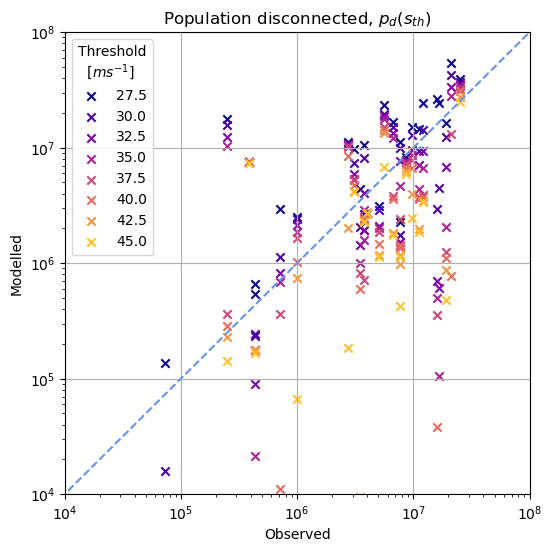

In [13]:
# scatter plot modelled vs. observed by threshold (same plot)

f, ax = plt.subplots(figsize=(6, 6))
    
for threshold in thresholds:
    df = data.loc[threshold, :, :]
    ax.scatter(df.observed, df.modelled, marker="x", label=threshold, color=wind_cmap[threshold])
    
x = np.linspace(0, 10 * max(data.observed), 100)
ax.plot(x, x, ls="--", c="cornflowerblue")
ax.grid()
ax.set_title("Population disconnected, $p_{d}(s_{th})$")
ax.set_xlabel("Observed")
ax.set_ylabel("Modelled")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1E4, 1E8)
ax.set_ylim(1E4, 1E8)
ax.legend(title="Threshold\n  $[m s^{{-1}}]$")

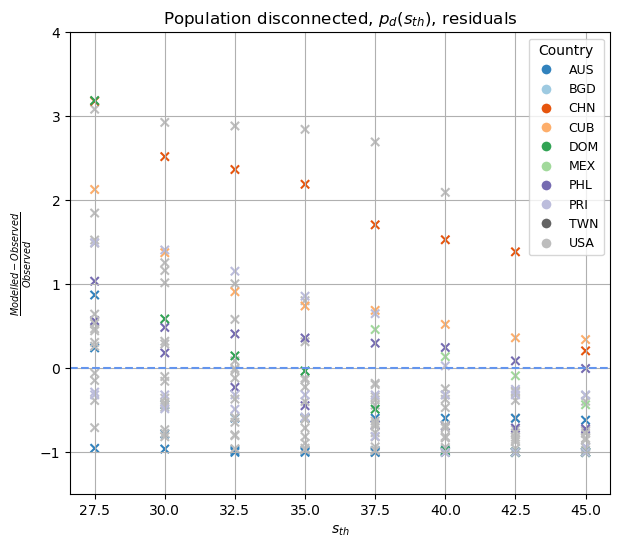

In [84]:
# scatter plot residual as a function of threshold

df = data["error_norm"].reset_index(["threshold", "country_iso_a3"])
colours = [country_cmap[value] for value in df.country_iso_a3.values]

f, ax = plt.subplots(figsize=(8,6))
ax.scatter(df.threshold, df.error_norm, c=colours, label="Country", marker="x")
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in country_cmap.items() if isinstance(k, str)]
ax.legend(title='Country', handles=handles, fontsize=9, loc="upper right")
ax.grid()
ax.axhline(0, ls="--", c="cornflowerblue")
ax.set_xlabel("$s_{th}$")
ax.set_ylabel(r"$\frac{Modelled - Observed}{Observed}$")
ax.set_title("Population disconnected, $p_{d}(s_{th})$, residuals")
ax.set_ylim(-1.5, 4)

plt.subplots_adjust(right=0.8)

# N.B. a couple of values are more more than 400% out, therefore out of plot area
# -1, worst possible score (model 100% underestimated)
# 0, perfect score
# + valued, progressively greater model overestimate

# N.B. our residuals, i.e. (mod - obs) / obs are not symmetric about 0 (-1 is the worst possible score)
# but we plot this measure as a) it's normalised, so can compare across scales
# and b) something like sign(mod - obs) * mod / obs, would give a perfect 0 for mod = 0  

In [87]:
def plot_residual_distribution_by_threshold(*, measure: str, x_label: str, x_min: float, x_max: float, bin_width: float, target: float = None):
    n = len(thresholds)
    ncols = min([n, 4])
    nrows = (n // ncols) + (n % ncols)
    f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 + 2.5 * ncols, 2 + 2.25 * nrows), squeeze=False)
    
    n_bins = int((x_max - x_min) / bin_width + 1)
    bins = np.linspace(x_min, x_max, n_bins)

    max_ylim = 0
    for row in range(nrows):
        for col in range(ncols):

            i = col + (row * ncols)
            ax = axes[row, col]
            if i < n:
                threshold = thresholds[i]
                residual = data.loc[threshold, :, :][measure]

                ax.grid()

                # distribution
                ax.hist(
                    residual,
                    bins=bins,
                    alpha=0.5,
                    label="Dist.",
                    facecolor=wind_cmap[threshold]
                )

                # rug plot
                ax.plot(residual, np.zeros(len(residual)), 'b|', ms=15, alpha=0.5, label="Data")

                # average measures
                mean = np.nanmean(residual)
                median = np.nanmedian(residual)
                ax.axvline(median, ls="--", c="red", label=r"$p_{50}$")
                ax.axvline(mean, ls="-", c="green", label=r"$\mu$")

                # target
                if target is not None:
                    ax.axvline(0, ls="--", c="cornflowerblue", label="Target")

                ax.set_xlim(x_min, x_max)
                _, max_y = ax.get_ylim()
                max_ylim = max([max_ylim, max_y])

                ax.set_title(f"$s_{{th}} = {threshold} \ m s^{{-1}}$", size=10)
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.35)
                ax.text(
                    0.95,
                    0.95,
                    "\n".join([f"$p_{{50}}$ = {median:.2f}", f"$\mu$ = {mean:.2f}"]),
                    transform=ax.transAxes,
                    fontsize=8,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=props
                )

            # disable any axes we don't need
            else:
                ax.set_axis_off()

    # set a common y range for all subplots
    for row in range(nrows):
        for col in range(ncols):
            i = col + (row * ncols)
            ax = axes[row, col]
            if i < n:
                ax.set_ylim(0, max_ylim)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    f.legend(by_label.values(), by_label.keys(), ncol=5, bbox_to_anchor=(0.68, 0.93))

    f.supxlabel(x_label)
    f.supylabel("Frequency")
    f.suptitle("Population disconnected, $p_{d}(s_{th})$, residuals")

    plt.subplots_adjust(bottom=0.1, top=0.82, left=0.08, right=0.87, hspace=0.3, wspace=0.25)

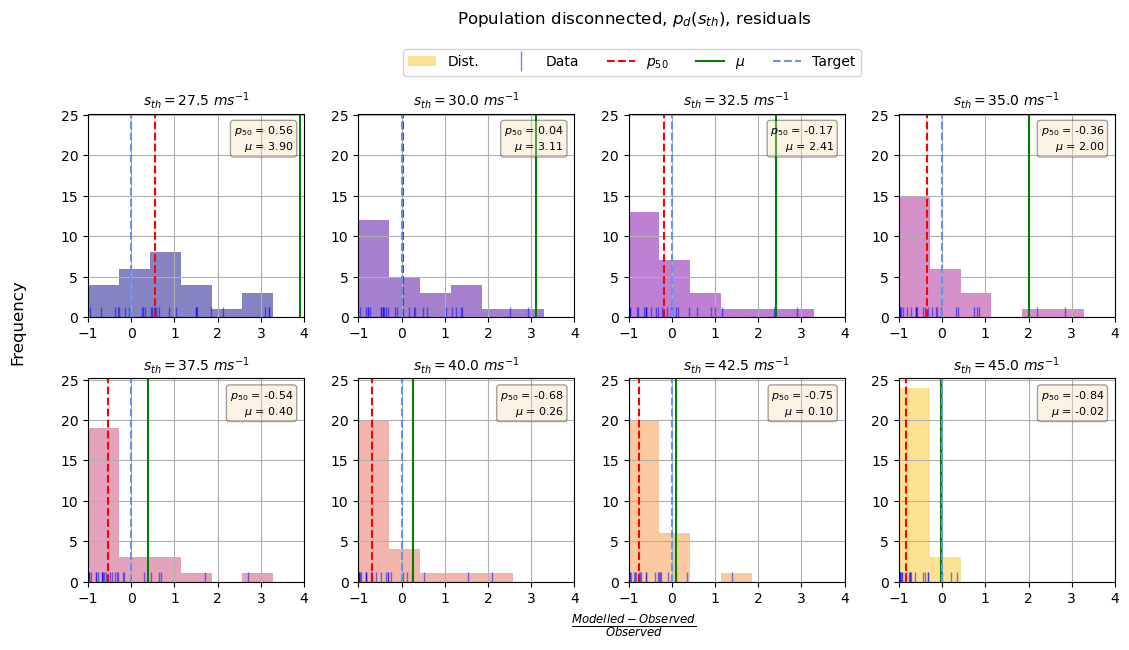

In [88]:
# plot residual distributions by threshold
plot_residual_distribution_by_threshold(
    measure="error_norm",
    x_label=r"$\frac{Modelled - Observed}{Observed}$",
    x_min=-1,
    x_max=4,
    bin_width=2/3,
    target=0
)

Text(0, 0.5, 'Frequency')

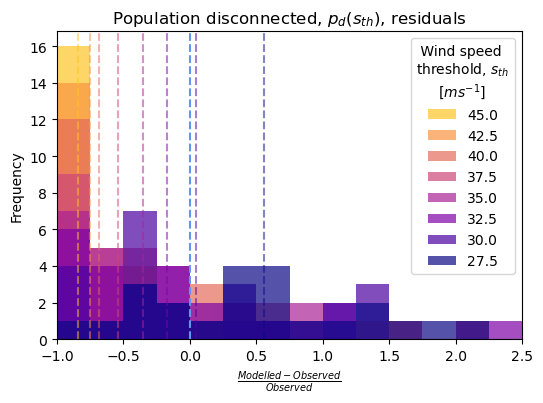

In [20]:
# over plot residual distributions by threshold

f, ax = plt.subplots(figsize=(6, 4))
for threshold in thresholds[::-1]:
    
    error_norm = data.loc[threshold, :, :].error_norm
    ax.hist(
        error_norm,
        bins=np.linspace(-1, 2.5, 15),
        alpha=0.7,
        label=threshold,
        color=wind_cmap[threshold]
    )
    ax.axvline(np.nanmedian(error_norm), ls="--", c=wind_cmap[threshold], alpha=0.5)
    
ax.axvline(0, ls="--", c="cornflowerblue")
    
ax.set_xlim(-1, 2.5)
ax.legend(title=" Wind speed\nthreshold, $s_{th}$\n     $[m s^{-1}]$")
ax.set_title("Population disconnected, $p_{d}(s_{th})$, residuals")
ax.set_xlabel(r"$\frac{Modelled - Observed}{Observed}$")
ax.set_ylabel("Frequency")